In [61]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"
os.environ["TF_FORCE_GPU_ALLOW_GROWTH"]="true"

import tensorflow as tf
import numpy as np

import plotly
import plotly.graph_objs as go


In [73]:
N = 1000
a = 2
s = 2
o = 4
f = s

A = np.array([[1,0,1,0], [0, 1, 0, 1]])
E = np.random.randn(o, s)

SA = np.random.randn(s + a, N)

Sx = SA[:s, :]
Ax = SA[s:, :]
Sy = A @ SA

Ox = E @ Sx
Oy = E @ Sy

In [74]:
assert np.all(Sx + Ax - Sy == 0)

In [75]:
D = np.random.randn(f, o)
Ms = np.random.randn(f, f)
Ma = np.random.randn(f, a)

In [76]:
D0 = np.linalg.pinv(E)
Ms0 = A[:, :2]
Ma0 = A[:, 2:]
D, Ms, Ma = D0, Ms0, Ma0

In [77]:
Fx = D @ Ox
Fy = D @ Oy

# Adding some deltas to $D$ and $M_s$

In [78]:
deltaD1 = np.random.randn(f, o)
deltaD2 = np.random.randn(f, o)

deltaMs = np.random.randn(f, f)

In [91]:
d1r = np.linspace(-1, 1, 100) * 10
d2r = np.linspace(-1, 1, 100) * 10

In [93]:
# preparing data for the 3d plot
X, Y, Z = [], [], []


for eps1 in d1r:
    for eps2 in d2r:
        D = D0 + eps1 * deltaD1 #+ eps2 * deltaD2
        Ms = Ms0 + eps2 * deltaMs

        l = Fy - Ms @ D @ Ox - Ma @ Ax
        l = np.linalg.norm(l, axis=1, ord=1)
        l = np.mean(l)
        loss = l
        
        #l = R @ D @ Ox - Oy
        #l = np.linalg.norm(l, axis=1, ord=1)
        #l = np.mean(l)
        loss += l
        X.append(eps1)
        Y.append(eps2)
        Z.append(loss)

# Doing 3d plot

# Configure the trace.
trace1 = go.Mesh3d(x=X, y=Y, z=Z, opacity=0.6)


# Configure the layout.
layout = go.Layout(
    margin={'l': 0, 'r': 0, 'b': 0, 't': 0}
)

data = [trace1]

plot_figure = go.Figure(data=data, layout=layout)

plot_figure.update_layout(scene = dict(xaxis_title='eps1',
                    yaxis_title='eps2',
                    zaxis_title='loss',
                    #xaxis_type="log",
                    #yaxis_type="log"
                                      ),
                    width=700,
                    margin=dict(r=20, b=10, l=10, t=10))


# Render the plot.
plotly.offline.iplot(plot_figure)

# Adding reconstruction loss

In [152]:
R0 = np.linalg.pinv(D)

In [153]:
deltaR = np.random.randn(o, f)
deltaD = np.random.randn(f, o)
D, Ms, Ma = D0, Ms0, Ma0

In [156]:
# preparing data for the 3d plot
X, Y, Z = [], [], []


for eps1 in d1r:
    for eps2 in d2r:
        D = D0 + eps1 * deltaD #+ eps2 * deltaD2
        Ms = Ms0 + eps2 * deltaMs
        #R = R0 + eps2 * deltaR

        l = Fy - Ms @ D @ Ox - Ma @ Ax
        l = np.linalg.norm(l, axis=1, ord=1)
        l = np.mean(l)
        loss = l
        
        l = R @ D @ Ox - Oy
        l = np.linalg.norm(l, axis=1, ord=1)
        l = np.mean(l)
        loss += l
        
        X.append(eps1)
        Y.append(eps2)
        Z.append(loss)

# Doing 3d plot

# Configure the trace.
trace1 = go.Mesh3d(x=X, y=Y, z=Z, opacity=0.5)


# Configure the layout.
layout = go.Layout(
    margin={'l': 0, 'r': 0, 'b': 0, 't': 0}
)

data = [trace1]

plot_figure = go.Figure(data=data, layout=layout)

plot_figure.update_layout(scene = dict(xaxis_title='eps1',
                    yaxis_title='eps2',
                    zaxis_title='loss',
                    #xaxis_type="log",
                    #yaxis_type="log"
                                      ),
                    width=700,
                    margin=dict(r=20, b=10, l=10, t=10))


# Render the plot.
plotly.offline.iplot(plot_figure)

# Gradients of pseudo-inverse in TensorFlow

In [133]:
# some variable
z = tf.Variable(np.array(A, dtype=np.float32))

In [134]:
# computing the gradient
with tf.GradientTape() as tape:
    z1 = tf.linalg.norm(tf.linalg.pinv(z))
tape.gradient(z1, z)

<tf.Tensor: shape=(2, 4), dtype=float32, numpy=
array([[-0.25000003,  0.        , -0.25000003,  0.        ],
       [ 0.        , -0.25000003,  0.        , -0.25000003]],
      dtype=float32)>

In [163]:
np.linalg.pinv(np.zeros((4, 4)) + 1e-10)

array([[6.25e+08, 6.25e+08, 6.25e+08, 6.25e+08],
       [6.25e+08, 6.25e+08, 6.25e+08, 6.25e+08],
       [6.25e+08, 6.25e+08, 6.25e+08, 6.25e+08],
       [6.25e+08, 6.25e+08, 6.25e+08, 6.25e+08]])

# Loss landscape when solved explictly for $M$
$L=0$ implies $DW_o=M_sD$ and $DW_a=M_a$. For our case, this means $M_s=DW_oD^{-1}$ and $M_a=DW_a$. $W$ is the transition matrix in the space of obeservations: $EA_a=W_a$ and $EA_s=W_oE$

Together: $DEA_s=M_sDE$ and $DEA_a=M_a$ which gives $M_s=DEA_s(DE)^{-1}$.

If we re-parameterize as $Z=DE$, $M_a=ZA_a$ and $M_s=ZA_sZ^{-1}$

Now, if $M_s=0$ (actions give next state, but there is no memory in the environment), the problem becomes Sparse Dictionary Learning.

Interpretation: find a basis where there are fewest components in $W_o$ and $W_a$

Can make $o=f$ just matrix $W$ has zero rows (sparsity) -- still optimal

In [40]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"
os.environ["TF_FORCE_GPU_ALLOW_GROWTH"]="true"

import tensorflow as tf
import numpy as np

import plotly
import plotly.graph_objs as go

from matplotlib import pyplot as plt
import seaborn as sns
from matplotlib import animation

from tqdm.notebook import tqdm

In [41]:
# observation, feature, action spaces dimensions
N = 10
o = N
f = N
a = N

# state/action transition matrices
#As = np.array([[0, 1], [1, 0]])
As = np.eye(N)
Aa = np.eye(N)

#As = np.random.randn(N, N) / N
#Aa = np.random.randn(N, N) / N

# encoder
E = np.random.randn(N, N)

In [42]:
# decoder
D = tf.Variable(np.random.randn(N, N))

def get_MfMa(D):
    """Get M_f, M_a from decoder."""
    Z = D @ E
    Mf = Z @ As @ tf.linalg.pinv(Z)
    Ma = Z @ Aa
    return Mf, Ma, Z

def Mflat(D):
    """Get model from decoder, flat."""
    Mf, Ma, Z = get_MfMa(D)
    Mflat = tf.reshape(tf.concat([Mf, Ma], axis=0), (-1,))
    return Mflat

In [43]:
def plot_heatmap():
    plt.title("Weights heatmap")
    cm = sns.diverging_palette(0, 129, l=70, s=100, n=20, center="dark")
    Mf, Ma, Z = get_MfMa(D)
    sns.heatmap(np.concatenate([Mf, Ma], axis=0), vmin=-1, vmax=1, cmap=cm)
    
def arr_of_dicts_to_dict_of_arrays(arr):
    """ Array of dicts to dict of arrays """
    all_keys = arr[0].keys()
    return {key: [v[key] for v in arr] for key in all_keys}

def process_results(losses):
    """Process experimental results."""
    # Plotting everything
    fig = plt.figure(figsize=(12, 5))
    fig.patch.set_facecolor('lightgreen')

    N_plots = len(losses) + 2

    plt.subplot(1, N_plots, 1)
    plt.title("d(M, A)")
    #plt.plot(distances, color='red')
    plt.axhline(0, ls='--', c='black')

    colormap = ['green', 'blue', 'green', 'blue', 'green']

    # model losses
    for i, key in enumerate(losses.keys()):
        plt.subplot(1, N_plots, 2 + i)
        plt.title(key)
        plt.plot(losses[key], c=colormap[i])
        plt.axhline(0, ls='--', c='black')
    
    plt.subplot(1, N_plots, N_plots)
    plot_heatmap()

    #plt.legend()
    plt.show()

In [44]:
def step(eps_dinv=.1):
    """One optimizer step."""
    # computing gradient
    with tf.GradientTape(persistent=True) as tape:
        tape.watch(D)
        v = Mflat(D)
        loss_l1 = tf.linalg.norm(v, ord=1)
        loss_dinv = tf.linalg.norm(tf.reshape(tf.linalg.pinv(D),
                                              (-1,)), ord=1)
        loss = loss_l1 + loss_dinv * eps_dinv
        
    grads = tape.gradient(loss, D)
    
    g1 = tape.gradient(loss_l1, D)
    g2 = tape.gradient(loss_dinv, D)

    g1 = tf.reshape(g1, (-1,)).numpy()
    g2 = tf.reshape(g2, (-1,)).numpy()
    cos = np.dot(g1, g2) / (np.linalg.norm(g1) * np.linalg.norm(g2) + 1e-20)

    
    grad_norm = tf.linalg.norm(tf.reshape(grads, (-1,)))
    optimizer.apply_gradients(zip([grads], [D]))
    return {'loss_l1': loss_l1.numpy(), 'grad_norm': grad_norm.numpy(),
            'loss_dinv': loss_dinv.numpy(), 'loss_total': loss.numpy(),
            'cos': cos}

In [59]:
#D = tf.Variable(np.random.randn(N, N) * 2)
D = tf.Variable(np.eye(N) + np.random.randn(N, N) * 2)
# optimizer choice
optimizer = tf.keras.optimizers.Adam(lr=5e-3)

In [60]:
epochs = 5000
losses = []
Ds = []
with tqdm(total=epochs) as pbar:
    for epoch in range(epochs):
        Ds.append(D.numpy())
        loss = step()
        losses.append(loss)
        pbar.update(1)
        pbar.set_postfix(**loss)
        #print(loss)
        #plot_heatmap()
        #plt.show()
losses = arr_of_dicts_to_dict_of_arrays(losses)

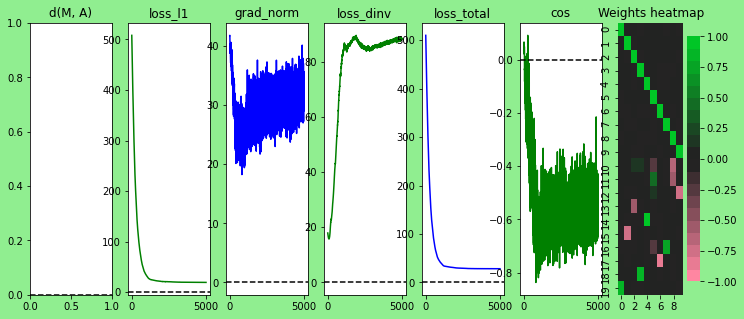

In [58]:
process_results(losses)

# Animation of weights

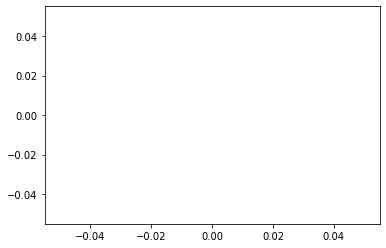

In [175]:
ims = []
fig, ax = plt.subplots()
line2d, = ax.plot([], [], lw=2)

ax_global = ax


def animate(i):
    #for i, d in enumerate(tqdm(Ds[::50])):
    d = Ds[::50][i]
    Z = d @ E
    Mf = Z @ As @ np.linalg.pinv(Z)
    Ma = Z @ Aa
    Mfa = np.concatenate([Mf, Ma], axis=0)
    #plt.figure()
    #plt.title("Weights heatmap frame=%d" % i)
    cm = sns.diverging_palette(0, 129, l=70, s=100, n=20, center="dark")
    im = sns.heatmap(Mfa, vmin=-1, vmax=1, cmap=cm, animated=True,
                     ax=ax_global, cbar=False)
    #plt.imshow(Mfa)
    #ims.append([im])
    #plt.savefig('image%05d.png' % i)
    #plt.close()

In [176]:
ani = animation.FuncAnimation(fig, animate, frames=len(Ds[::50]))

In [177]:
from IPython.display import HTML
HTML(ani.to_jshtml())

# 3D loss plot + descent curve in PCA space

In [210]:
Dflats = []
losses_ = []
for i, d in enumerate(tqdm(Ds)):
    Z = d @ E
    dflat = d.flatten()
    Mf = Z @ As @ np.linalg.pinv(Z)
    Ma = Z @ Aa
    Mfa = np.concatenate([Mf, Ma], axis=0)
    Mfaflat = Mfa.flatten()
    loss = np.linalg.norm(Mfaflat, ord=1)
    Dflats.append(dflat)
    losses_.append(loss)

In [211]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
Dflats_pca = pca.fit_transform(Dflats)

In [212]:
np.min(Dflats_pca, axis=0), np.max(Dflats_pca, axis=0)

(array([-3.62145201, -2.71804324]), array([13.31578095,  4.836161  ]))

In [213]:
pca.inverse_transform(Dflats_pca)

array([[-0.28687163,  1.28885721, -0.0269992 , ..., -2.15378403,
        -3.71184603,  0.06657008],
       [-0.28528043,  1.28949314, -0.02815942, ..., -2.15110937,
        -3.71053381,  0.06449682],
       [-0.28373398,  1.29016092, -0.02922485, ..., -2.14857498,
        -3.70939813,  0.06232391],
       ...,
       [ 0.80399479,  1.33488167, -1.30974272, ...,  0.18985824,
        -1.71759506, -0.11645879],
       [ 0.80399885,  1.33486797, -1.30976483, ...,  0.1898851 ,
        -1.7175487 , -0.11641543],
       [ 0.80401883,  1.33487138, -1.3097851 , ...,  0.18992466,
        -1.7175194 , -0.11642694]])

In [214]:
xs = np.linspace(-2, 2, 50) * 10
ys = np.linspace(-2, 2, 50) * 10
xys = []
X = []
Y = []
for x in xs:
    for y in ys:
        xys.append((x, y))
        X.append(x)
        Y.append(y)

In [215]:
losses__ = []
for d in pca.inverse_transform(xys):
    d = d.reshape(N, N)
    Z = d @ E
    Mf = Z @ As @ np.linalg.pinv(Z)
    Ma = Z @ Aa
    Mfa = np.concatenate([Mf, Ma], axis=0)
    Mfaflat = Mfa.flatten()
    loss = np.linalg.norm(Mfaflat, ord=1)
    #M = max(losses_)
    M = 1000
    losses__.append(min(M, loss))

In [216]:
# Doing 3d plot

Z = losses__

# Configure the trace.
trace1 = go.Mesh3d(x=X, y=Y, z=Z, opacity=0.5)

trace2 = go.Scatter3d(x=Dflats_pca[:, 0], y=Dflats_pca[:, 1], z=losses_,
    marker=dict(
        size=4,
        color=losses_,
        colorscale='Viridis',
    ),
    line=dict(
        color='darkblue',
        width=2
    )
)

# Configure the layout.
layout = go.Layout(
    margin={'l': 0, 'r': 0, 'b': 0, 't': 0}
)

data = [trace1, trace2]

plot_figure = go.Figure(data=data, layout=layout)

plot_figure.update_layout(scene = dict(xaxis_title='eps1',
                    yaxis_title='eps2',
                    zaxis_title='loss',
                    #xaxis_type="log",
                    #yaxis_type="log"
                                      ),
                    width=700,
                    margin=dict(r=20, b=10, l=10, t=10))


# Render the plot.
plotly.offline.iplot(plot_figure)

In [84]:
loss

897.849175949347

In [349]:
Mf, Ma, Z = get_MfMa(D)

In [350]:
Ma

<tf.Tensor: shape=(2, 2), dtype=float64, numpy=
array([[-6.97086123e-04, -1.02828090e+00],
       [-1.41185463e+00, -1.56467632e-02]])>

In [351]:
tf.linalg.pinv(D)

<tf.Tensor: shape=(2, 2), dtype=float64, numpy=
array([[ 1.03869703e+00,  6.07167713e-01],
       [-5.30153619e-06, -8.21074549e-01]])>

In [352]:
D

<tf.Variable 'Variable:0' shape=(2, 2) dtype=float64, numpy=
array([[ 9.62748273e-01,  7.11932513e-01],
       [-6.21629890e-06, -1.21792080e+00]])>

In [353]:
D @ E @ Aa, Ma

(<tf.Tensor: shape=(2, 2), dtype=float64, numpy=
 array([[-6.97086123e-04, -1.02828090e+00],
        [-1.41185463e+00, -1.56467632e-02]])>,
 <tf.Tensor: shape=(2, 2), dtype=float64, numpy=
 array([[-6.97086123e-04, -1.02828090e+00],
        [-1.41185463e+00, -1.56467632e-02]])>)

# 3D plot for the loss

In [485]:
# preparing data for the 3d plot
X, Y, Z = [], [], []

d1r = np.linspace(-1, 1, 100) * 1
d2r = np.linspace(-1, 1, 100) * 1

D0 = np.linalg.pinv(E)

deltaD1 = np.random.randn(2, 2)
deltaD2 = np.random.randn(2, 2)

for eps1 in d1r:
    for eps2 in d2r:
        D = D0 + eps1 * deltaD1 + eps2 * deltaD2
        Mf, Ma, _ = get_MfMa(D)
        Mflat = np.reshape(np.concatenate([Mf, Ma], axis=0), (-1,))
        loss = np.linalg.norm(Mflat, ord=1)
        Dinvflat = np.linalg.norm(np.linalg.pinv(D).flatten(), ord=1)
        X.append(eps1)
        Y.append(eps2)
        
        L = loss + Dinvflat
        L = min(L, 100)
        
        Z.append(L)

# Doing 3d plot

# Configure the trace.
trace1 = go.Mesh3d(x=X, y=Y, z=Z, opacity=0.5)


# Configure the layout.
layout = go.Layout(
    margin={'l': 0, 'r': 0, 'b': 0, 't': 0}
)

data = [trace1]

plot_figure = go.Figure(data=data, layout=layout)

plot_figure.update_layout(scene = dict(xaxis_title='eps1',
                    yaxis_title='eps2',
                    zaxis_title='loss',
                    #xaxis_type="log",
                    #yaxis_type="log"
                                      ),
                    width=700,
                    margin=dict(r=20, b=10, l=10, t=10))


# Render the plot.
plotly.offline.iplot(plot_figure)